<a href="https://colab.research.google.com/github/aricahyasaputra/machine-learning-course-assigment/blob/main/Minggu%207%20XGBoost/Tugas_Minggu_7_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



Nama : Ari Cahya Saputra

NIM : 1103190093

Kelas : TK-42-PIL1


#NYCT - from A to Z with XGBoost (Tutorial)

Karena batas file upload github hanya 25MB maka saya uplolad data set nya di drive saya dengan link berikut https://drive.google.com/drive/folders/16JyiPsCs2fcIqfK-DZn3wZciUG6vpxzS?usp=sharing

[Reference](https://www.kaggle.com/code/karelrv/nyct-from-a-to-z-with-xgboost-tutorial/notebook)

### The Libraries and Function

In [ ]:
%matplotlib inline
import pandas as pd
from datetime import datetime
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.linear_model import LinearRegression, Ridge,BayesianRidge
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import mean_squared_error
from math import radians, cos, sin, asin, sqrt
import seaborn as sns
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]

In [ ]:
# Connect google collab with google drive
from google.colab import drive 
drive.mount ('/content/drive')

Mounted at /content/drive


In [ ]:
# Loading data
train = pd.read_csv('/content/drive/MyDrive/Machine Learning Course Material/Minggu 7 XGBoost/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Machine Learning Course Material/Minggu 7 XGBoost/test.csv')

### File Structure

In [ ]:
pd.set_option('display.float_format', lambda x: '%.3f' % x) # customize some aspects of its behavior, display-related options
train.head() # head here only displays the top 5 data

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982,40.768,-73.965,40.766,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980,40.739,-73.999,40.731,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979,40.764,-74.005,40.710,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010,40.720,-74.012,40.707,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973,40.793,-73.973,40.783,N,435


###### Note the use of `pd.set_option('display.float_format', lambda x: '%.3f' % x)` to set the display options. More on that [here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.set_option.html "Pandas set_option").

###### You can also use `train.tail()` to display the last 5 entries in the two files. From the output we can get an idea of the way the data is structured. Of course, this isn't strictly necessary, since it is possible to get the same view by navigating to the *Input Files* at the top and clicking on any one of the CSV files used in this analysis.

### Data Summary

In [ ]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
train.describe() # display a summary of statistical data

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000
mean,1.535,1.665,-73.973,40.751,-73.973,40.752,959.492
std,0.499,1.314,0.071,0.033,0.071,0.036,5237.432
min,1.000,0.000,-121.933,34.360,-121.933,32.181,1.000
25%,1.000,1.000,-73.992,40.737,-73.991,40.736,397.000
50%,2.000,1.000,-73.982,40.754,-73.980,40.755,662.000
75%,2.000,2.000,-73.967,40.768,-73.963,40.770,1075.000
max,2.000,9.000,-61.336,51.881,-61.336,43.921,3526282.000


In [ ]:
train.info() # info() - print a concise summary of a DataFrame.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


### Trip Duration Clean-Up
###### As we noted earlier there are some outliers associated with the `trip_duration` variable, specifically a 980 hour maximum trip duration and a minimum of 1 second trip duration. I've decided to exclude data that lies outside 2 standard deviations from the mean. It might be worthwhile looking into what effect excluding up to 4 standard deviations would have on the end-results.

In [ ]:
m = np.mean(train['trip_duration'])
s = np.std(train['trip_duration'])
train = train[train['trip_duration'] <= m + 2*s]
train = train[train['trip_duration'] >= m - 2*s]

### Latitude and Longitude Clean-up
###### Looking into it, the borders of NY City, in coordinates comes out to be:

city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

Comparing this to our `train.describe()` output we see that there are some coordinate points (pick ups/drop offs) that fall outside these borders. So let's limit our area of investigation to within the NY City borders.

In [ ]:
train = train[train['pickup_longitude'] <= -73.75]
train = train[train['pickup_longitude'] >= -74.03]
train = train[train['pickup_latitude'] <= 40.85]
train = train[train['pickup_latitude'] >= 40.63]
train = train[train['dropoff_longitude'] <= -73.75]
train = train[train['dropoff_longitude'] >= -74.03]
train = train[train['dropoff_latitude'] <= 40.85]
train = train[train['dropoff_latitude'] >= 40.63]

### Date Clean-up
###### As a final step in preparing our data we need to change the formatting of the date variables (`pickup_datetime` and `dropoff_datetime`). This will help a lot with data extraction in the coming section.


In [ ]:
# pd.to_datatime - Convert argument to datetime.
train['pickup_datetime'] = pd.to_datetime(train.pickup_datetime)
test['pickup_datetime'] = pd.to_datetime(test.pickup_datetime)
train.loc[:, 'pickup_date'] = train['pickup_datetime'].dt.date
test.loc[:, 'pickup_date'] = test['pickup_datetime'].dt.date
train['dropoff_datetime'] = pd.to_datetime(train.dropoff_datetime) #Not in Test

### Initial Analysis
###### Let's plot a simple histogram of the trip duration, throwing the data into 100 bins. Change this around to get a feel for what binning does to your data. Simply put, binning involves taking your data's max and min points, subtracting it to get the length, dividing that length by the number of bins to get the interval length, and grouping the data points into those intervals. Here's what that looks like:

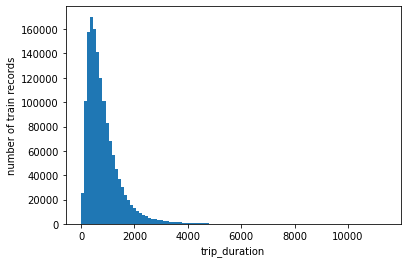

In [ ]:
plt.hist(train['trip_duration'].values, bins=100)
plt.xlabel('trip_duration') # title for x
plt.ylabel('number of train records') # title for y
plt.show() # show

###### This is a good opportunity to play with some data transformations to see if notable patterns emerge in the data when applying certain transforms, for example a log transform. In this case, applying a log transformation to the trip duration makes sense, since we are doing this to accommodate the leaderboard's scoring metric. That would look like this:

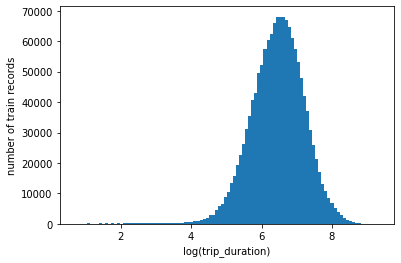

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


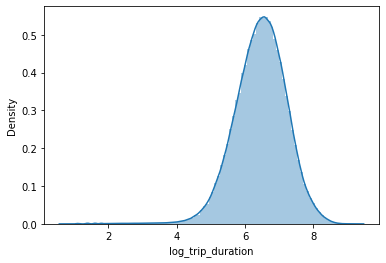

In [ ]:
train['log_trip_duration'] = np.log(train['trip_duration'].values + 1)
# bins - the range of values that is, divide the entire range of values into a series of intervals.
plt.hist(train['log_trip_duration'].values, bins=100)
plt.xlabel('log(trip_duration)')
plt.ylabel('number of train records')
plt.show()
sns.distplot(train["log_trip_duration"], bins =100)

###### One might also be interested to view the number of trips over time, since this could reveal not only apparent seasonality in the data and certain trends, but could point out any siginficant outliers (if not already cleaned out of the data set of course) and indicate missing values (again, only if it wasn't already checked and cleaned in the data set).

For this we'll simply plot a timeseries line graph of both the test and training data to not only look into identifying possible trends/seasonality but to see if both data sets follow the same pattern shape. Reasonably we'd expect the two datasets to follow a very similar shape since the test data would be/is a randomly selected sample from the original dataset containing all data points. By picking the test points randomly, each data point has the same likelihood of being picked as a test point, thus ensuring uniformity in the test data sample.

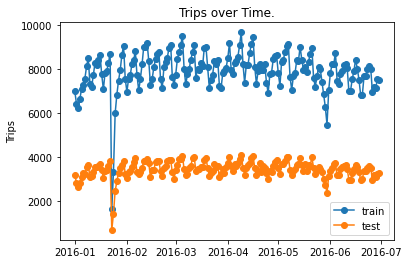

In [ ]:
plt.plot(train.groupby('pickup_date').count()[['id']], 'o-', label='train')
plt.plot(test.groupby('pickup_date').count()[['id']], 'o-', label='test')
plt.title('Trips over Time.')
plt.legend(loc=0)
plt.ylabel('Trips')
plt.show()

###### Clearly the test and train datasets follow a very simila shape, as expected. A couple of points stand out at first glance. Around late-Jan/early-Feb there is a massive drop in the number of trips taken. A slightly less drastic drop is apparent about four months later. The first drop could be related to the season: it's winter in New York so you'd expect less trips being taken (who wants to ride around when it's near freezing outside?). However, this seems unlikely because the dip looks to be isolated around a single day or couple of days. In my opinion there's a greater chance that there were strikes (if you've got the South African mindset I do, but this is New York, so probably not that) or that there was an issue with the data system recording the trips. Whatever the reason, it's worth noting these 'outliers'.

Let's see how significantly (or not significantly at all) the two vendors differ in their respective mean trip durations:

No handles with labels found to put in legend.


Text(0, 0.5, 'Time in Seconds')

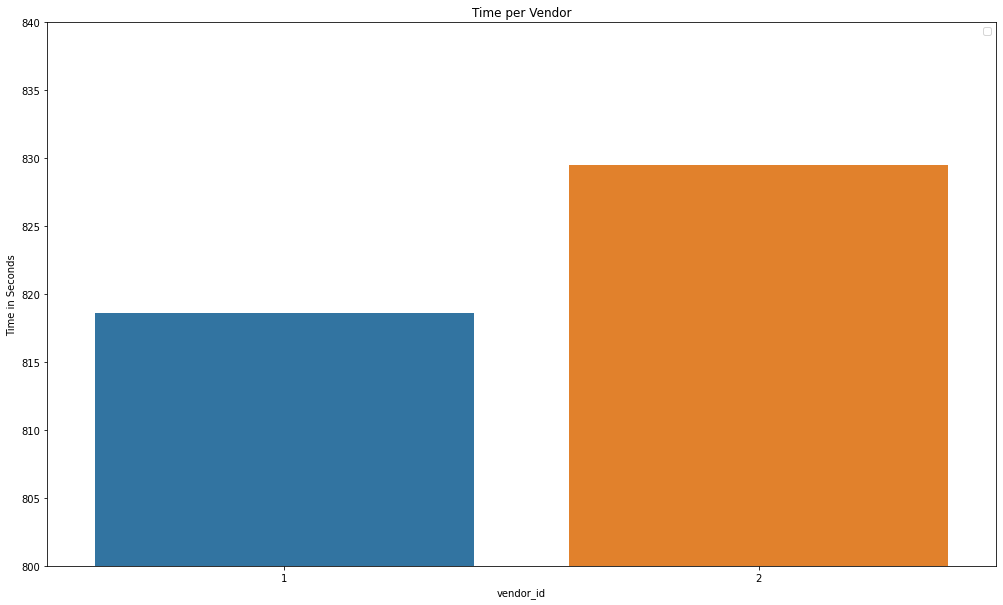

In [ ]:
import warnings
warnings.filterwarnings("ignore")
plot_vendor = train.groupby('vendor_id')['trip_duration'].mean() # groupby - divide the data into separate groups to perform calculations for better analysis.
plt.subplots(1,1,figsize=(17,10))
plt.ylim(ymin=800)
plt.ylim(ymax=840)
sns.barplot(plot_vendor.index,plot_vendor.values)
plt.title('Time per Vendor')
plt.legend(loc=0)
plt.ylabel('Time in Seconds')

###### So it doesn't look like there's much of a difference between travel times for the two vendors. One would assume that knowing which routes are the fastest to take from A to B is no secret, and that it is more a trick of the trade, rather than IP. But something doesn't look right, so there's another feature we can use to see if after all there is a significant difference in mean travel time: the `store_and_fwd_flag`.

No handles with labels found to put in legend.


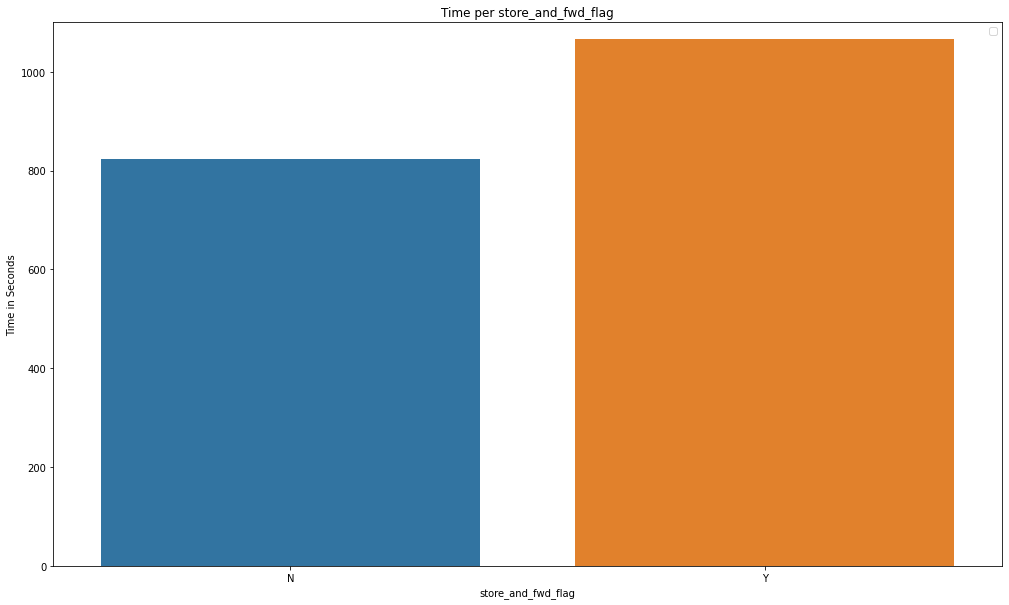

In [ ]:
snwflag = train.groupby('store_and_fwd_flag')['trip_duration'].mean()

plt.subplots(1,1,figsize=(17,10))
plt.ylim(ymin=0)
plt.ylim(ymax=1100)
plt.title('Time per store_and_fwd_flag')
plt.legend(loc=0)
plt.ylabel('Time in Seconds')
sns.barplot(snwflag.index,snwflag.values)

###### So it would seem that the `store_and_fwd_flag` discriminates well between travel times. Clearly there is a slight skew in the data where some of the vendor employees didn't record their travel times accurately.

As mentioned earlier when digging into the variables, I thought about the impact that the number of passengers per trip might have on travel time. The thought process was that more passengers might equal more stops, hence prolonging the travel time from start to finish (unless the different drop-offs were recorded as separate trips). So in order to find out if there is infact a significant influence in travel time, let's group the mean travel times by the `passenger_count`:

No handles with labels found to put in legend.


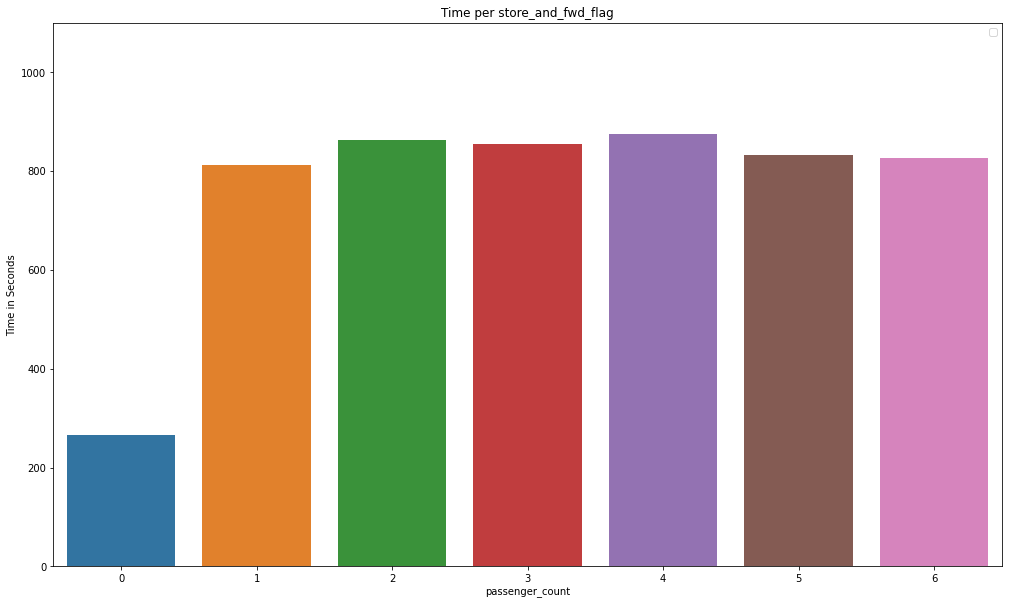

In [ ]:
pc = train.groupby('passenger_count')['trip_duration'].mean()

plt.subplots(1,1,figsize=(17,10))
plt.ylim(ymin=0)
plt.ylim(ymax=1100)
plt.title('Time per store_and_fwd_flag')
plt.legend(loc=0)
plt.ylabel('Time in Seconds')
sns.barplot(pc.index,pc.values)

###### So no significant difference evident that could be explained by the number of passengers in the vehicle for any given trip. It is interesting to note that there is are on average +-4min trips associated with no passengers. This is probably a mistake made in recording the data unless the vendor employee is into charging him/herself for trips whilst on the job.

Again, we need to check whether the test and train data matches with respect to the number of trips containing X-number of passengers:

In [ ]:
train.groupby('passenger_count').size()

passenger_count
0         52
1    1018715
2     206864
3      58989
4      27957
5      76912
6      47639
dtype: int64

In [ ]:
test.groupby('passenger_count').size()

passenger_count
0        23
1    443447
2     90027
3     25686
4     12017
5     33411
6     20521
9         2
dtype: int64

### Pickup Locations
###### To do this, we utilise the city map border coordinates for New York, mentioned earlier in the kernel to create the canvas wherein the coordinate points will be graphed. To display the actual coordinates a simple scatter plot is used:

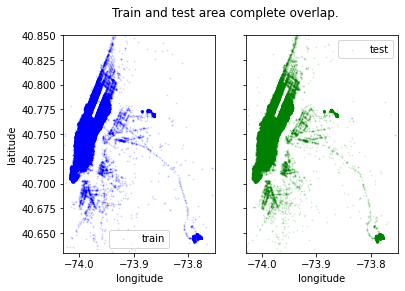

In [ ]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
# sharex - used to link the x axes of subplots in the resulting figure.
# sharey - used to link the y axes of subplots in the resulting figure. 
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True)
# alpha - The alpha blending value, between 0 (transparent) and 1 (opaque).
ax[0].scatter(train['pickup_longitude'].values[:100000], train['pickup_latitude'].values[:100000],
              color='blue', s=1, label='train', alpha=0.1)
ax[1].scatter(test['pickup_longitude'].values[:100000], test['pickup_latitude'].values[:100000],
              color='green', s=1, label='test', alpha=0.1)
fig.suptitle('Train and test area complete overlap.')
ax[0].legend(loc=0)
ax[0].set_ylabel('latitude')
ax[0].set_xlabel('longitude')
ax[1].set_xlabel('longitude')
ax[1].legend(loc=0)
plt.ylim(city_lat_border)
plt.xlim(city_long_border)
plt.show()

###### We can tell from the two graphs that the pickup locations are quite similar, with the notable difference being that the train data set simply has more data points (which makes sense).

### Distance and Directionality
###### We can determine the distance and direction of a specific trip based on the pickup and dropoff coordinates. For this I've made three functions, as:

In [ ]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b

def bearing_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

###### Applying these functions to both the test and train data, we can calculate the haversine distance which is the great-circle distance between two points on a sphere given their longitudes and latitudes. We can then calculate the summed distance traveled in Manhattan. And finally we calculate (through some handy trigonometry) the direction (or bearing) of the distance traveled. These calculations are stored as variables in the separate data sets. The next step I decided to take is to create neighourhods, like Soho, or the Upper East Side, from the data and display this.

In [ ]:
# loc - Access a group of rows and columns by label(s) or a boolean array.
train.loc[:, 'distance_haversine'] = haversine_array(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
test.loc[:, 'distance_haversine'] = haversine_array(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)    
    
train.loc[:, 'distance_dummy_manhattan'] =  dummy_manhattan_distance(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
test.loc[:, 'distance_dummy_manhattan'] =  dummy_manhattan_distance(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)

train.loc[:, 'direction'] = bearing_array(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
test.loc[:, 'direction'] = bearing_array(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)

### Lets create the "Neighborhoods"
###### One might think it necessary to have a map handy to do this, but not really. This will intuitively work as KMeans will cluster the data points into their own neighborhoods. This is pretty straight forward since Numpy helps create a vertically stacked array of the pickup and dropoff coordinates, and using `sklearn`'s MiniBatchKMeans module it's easy to set up the parameters to create the clusters.

There are three steps to preparing the data: create the coordinates stack, configure the KMeans clustering parameters, and create the actual clusters:

In [ ]:
# vstack - Stack arrays in sequence vertically (row wise).
coords = np.vstack((train[['pickup_latitude', 'pickup_longitude']].values,
                    train[['dropoff_latitude', 'dropoff_longitude']].values))

In [ ]:
# np.random.permutation - Randomly permute a sequence, or return a permuted range.
sample_ind = np.random.permutation(len(coords))[:500000]
kmeans = MiniBatchKMeans(n_clusters=100, batch_size=10000).fit(coords[sample_ind])

In [ ]:
train.loc[:, 'pickup_cluster'] = kmeans.predict(train[['pickup_latitude', 'pickup_longitude']])
train.loc[:, 'dropoff_cluster'] = kmeans.predict(train[['dropoff_latitude', 'dropoff_longitude']])
test.loc[:, 'pickup_cluster'] = kmeans.predict(test[['pickup_latitude', 'pickup_longitude']])
test.loc[:, 'dropoff_cluster'] = kmeans.predict(test[['dropoff_latitude', 'dropoff_longitude']])

###### Once you've run through these steps, you're all set to display these clusters in a similar way than the pickup locations. So as an example, I'll graph the pickup location clusters. Again, the map is drawn on the New York border coordinates canvas we created earlier:

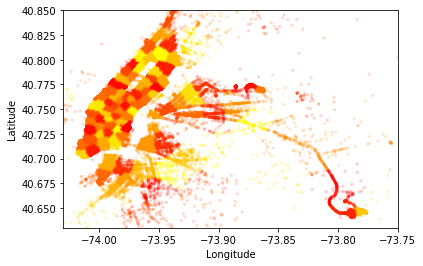

In [ ]:
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.scatter(train.pickup_longitude.values[:500000], train.pickup_latitude.values[:500000], s=10, lw=0,
           c=train.pickup_cluster[:500000].values, cmap='autumn', alpha=0.2)
ax.set_xlim(city_long_border)
ax.set_ylim(city_lat_border)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

###### This shows a nice visual representation of the KMeans clustering algorithm at work (we used 100 clusters, but there is freedom to play around with this parameter to see how it changes the results). The clustering effectively created the different neighbourhoods in Manhattan as displayed by the borders between the different colors. This should be intuitive to some degree as a trip would differ from point A to point B, in various parts of New york. By nature, it's different.

The next step is to start looking into extracting information from the dates and starting to think about encoding the data.

### Date Extraction
###### Part of the reasoning behind extracting the different parts of the date for each trip is to enable us to do one hot encoding. This involves changing categorical variables into binary variables. It makes it easier to use when training ML models, since logically a machine can much better understand 1's and 0's rather than 'January' or 'Febuary', for example. You can read more on one hot encoding [here](http://machinelearningmastery.com/how-to-one-hot-encode-sequence-data-in-python/ "One Hot Encoding"). To make sure we can use the features we extract from the dates, we need to check if both data sets has the same size (i.e. same number of months, days, hours, etc.).

In [ ]:
#Extracting Month
train['Month'] = train['pickup_datetime'].dt.month
test['Month'] = test['pickup_datetime'].dt.month

In [ ]:
train.groupby('Month').size(),test.groupby('Month').size()

(Month
 1    226444
 2    235054
 3    252443
 4    247855
 5    244591
 6    230741
 dtype: int64, Month
 1     97676
 2    102314
 3    109697
 4    107432
 5    107570
 6    100445
 dtype: int64)

###### Both train and test data sets have 6 months, so months are ready for dummy variables (i.e. encoding).

In [ ]:
train['DayofMonth'] = train['pickup_datetime'].dt.day
test['DayofMonth'] = test['pickup_datetime'].dt.day
len(train.groupby('DayofMonth').size()),len(test.groupby('DayofMonth').size())

(31, 31)

###### Both train and test data sets have 31 days, so days are ready for dummy variables (i.e. encoding).

In [ ]:
train['Hour'] = train['pickup_datetime'].dt.hour
test['Hour'] = test['pickup_datetime'].dt.hour
len(train.groupby('Hour').size()),len(test.groupby('Hour').size())

(24, 24)

###### Both train and test data sets have 24 hours, so hours are ready for dummy variables (i.e. encoding).

In [ ]:
train['dayofweek'] = train['pickup_datetime'].dt.dayofweek
test['dayofweek'] = test['pickup_datetime'].dt.dayofweek
len(train.groupby('dayofweek').size()),len(test.groupby('dayofweek').size())

(7, 7)

###### Both sets of data has 7 days per week. That's fine for encoding aswell.

###### So, excellent! We can safely use the different date parts in their extracted forms as part of the modelling process. Let's take a look at the average speed and how it changes over time, specifically focusing on how the hour of the day, the day of the week, and the moth of the year affects average speed. It's important to note though that average speed is a function of distance and time so it wouldn't add anything to the modelling output. We'll therefore need to remove it eventually before we train our model.

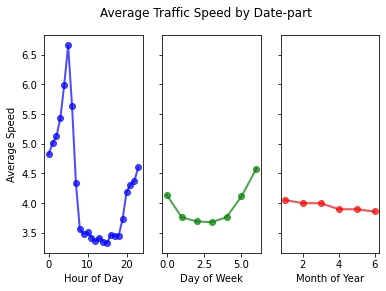

In [ ]:
train.loc[:, 'avg_speed_h'] = 1000 * train['distance_haversine'] / train['trip_duration']
train.loc[:, 'avg_speed_m'] = 1000 * train['distance_dummy_manhattan'] / train['trip_duration']
fig, ax = plt.subplots(ncols=3, sharey=True)
ax[0].plot(train.groupby('Hour').mean()['avg_speed_h'], 'bo-', lw=2, alpha=0.7)
ax[1].plot(train.groupby('dayofweek').mean()['avg_speed_h'], 'go-', lw=2, alpha=0.7)
ax[2].plot(train.groupby('Month').mean()['avg_speed_h'], 'ro-', lw=2, alpha=0.7)
ax[0].set_xlabel('Hour of Day')
ax[1].set_xlabel('Day of Week')
ax[2].set_xlabel('Month of Year')
ax[0].set_ylabel('Average Speed')
fig.suptitle('Average Traffic Speed by Date-part')
plt.show()

###### So the interesting thing to notice here is the average speed by hour of day. We're I'm from traffic usually peaks between 5am and 9am, and then again from about 4pm to around 6 or 7pm. But it would seem in manhattan that average speed diminishes as the day goes by from around 6am and picks up again around 7 or 8pm. So most of the travelling in the Big Apple happens during work hours. The average speed by weekday follows an expected trend. Over the weekend (Friday, Saturday, Sunday) the average speed picks up quite nicely, indicating less traffic. Finally, the average trip speed by month follows an expected trend. In the winter months there are less trips (see the previous timeseries plot we made) indicating less traffic in general in the city which means you can average a higher speed on the roads.


This next part uses the pick-up locations and the average speed data we've got and plots the average speed by location.

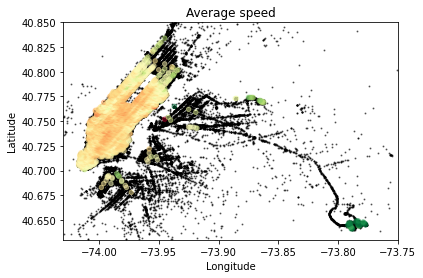

In [ ]:
# np.random - Round an array to the given number of decimals.
train.loc[:, 'pickup_lat_bin'] = np.round(train['pickup_latitude'], 3)
train.loc[:, 'pickup_long_bin'] = np.round(train['pickup_longitude'], 3)
# Average speed for regions
gby_cols = ['pickup_lat_bin', 'pickup_long_bin']
coord_speed = train.groupby(gby_cols).mean()[['avg_speed_h']].reset_index()
coord_count = train.groupby(gby_cols).count()[['id']].reset_index()
coord_stats = pd.merge(coord_speed, coord_count, on=gby_cols) # Merge DataFrame or named Series objects with a database-style join.
coord_stats = coord_stats[coord_stats['id'] > 100]
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.scatter(train.pickup_longitude.values[:500000], train.pickup_latitude.values[:500000], color='black', s=1, alpha=0.5)
ax.scatter(coord_stats.pickup_long_bin.values, coord_stats.pickup_lat_bin.values, c=coord_stats.avg_speed_h.values,
           cmap='RdYlGn', s=20, alpha=0.5, vmin=1, vmax=8)
ax.set_xlim(city_long_border)
ax.set_ylim(city_lat_border)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.title('Average speed')
plt.show()

###### So clearly, by neighbourhood, the average speed definitely changes. To a greater extent the center of the city is the busiest (we'd expect this since the majority of activity in large cities is focused around the center) and the average speed picks up nicely around the outskirts.


We can expect good performance from our clustering data during modelling just from looking at how well we can distinguish average speeds by neighbourhood (i.e. cluster). Something definitely worth exploring, which could boost the performance of the XGBoost model significantly, is to create a data set that can be used with [Xiaolin Wu's line algorithm](https://en.m.wikipedia.org/wiki/Xiaolin_Wu%27s_line_algorithm "Xiaolin Wu's line algorithm"). This would involve pixelating the graph area and recording every pixel crossed by the line from the pick-up location to the drop-off location. If you can make the resolution as high as possible some of the pixels shoudl encapsulate traffic junctions, traffic lights, bridges, etc. Using the "has crossed coordinate X" features one could potentially create an extra +-10 000 features to train the alogrithm with.


### Data Enrichment
### Data is not found, so only write the code without running.

In [ ]:
fr1 = pd.read_csv('../input/new-york-city-taxi-with-osrm/fastest_routes_train_part_1.csv', usecols=['id', 'total_distance', 'total_travel_time',  'number_of_steps'])
fr2 = pd.read_csv('../input/new-york-city-taxi-with-osrm/fastest_routes_train_part_2.csv', usecols=['id', 'total_distance', 'total_travel_time', 'number_of_steps'])
test_street_info = pd.read_csv('../input/new-york-city-taxi-with-osrm/fastest_routes_test.csv',
                               usecols=['id', 'total_distance', 'total_travel_time', 'number_of_steps'])
train_street_info = pd.concat((fr1, fr2)) # Concatenate pandas objects along a particular axis with optional set logic along the other axes.
# The merge () method updates the content of two DataFrame by merging them together, using the specified method (s).
train = train.merge(train_street_info, how='left', on='id')
test = test.merge(test_street_info, how='left', on='id')

In [ ]:
train.shape, test.shape # Return a tuple representing the dimensionality of the DataFrame.

###### Strictly speaking we don't need to check the content/shape of the data, but for sanity we can check what the test and training data sets look like. The output makes sence: The columns that the train dataset has that test doesn't is now: `dropoff_datetime`, `avg_speed_m`, `avg_speed_h`, `pickup_lat_bin`, and `pickup_long_bin` (apart from `trip_duration`).


Now for the scary part (not really): Creating the dummy variables.

###  Creating Dummy Variables
###### So for this step we get to the one hot encoding we spoke of earlier. Generally speaking you can do this in a few ways, but luckily Pandas helps us out again. A simple function that changes categorical data into dummy/indicator variables.

In [ ]:
# pd.get_dummies - Convert categorical variable into dummy/indicator variables.
# prefix - String to append DataFrame column names.
# If appending prefix, separator/delimiter to use. Or pass a list or dictionary as with prefix.
vendor_train = pd.get_dummies(train['vendor_id'], prefix='vi', prefix_sep='_')
vendor_test = pd.get_dummies(test['vendor_id'], prefix='vi', prefix_sep='_')
passenger_count_train = pd.get_dummies(train['passenger_count'], prefix='pc', prefix_sep='_')
passenger_count_test = pd.get_dummies(test['passenger_count'], prefix='pc', prefix_sep='_')
store_and_fwd_flag_train = pd.get_dummies(train['store_and_fwd_flag'], prefix='sf', prefix_sep='_')
store_and_fwd_flag_test = pd.get_dummies(test['store_and_fwd_flag'], prefix='sf', prefix_sep='_')
cluster_pickup_train = pd.get_dummies(train['pickup_cluster'], prefix='p', prefix_sep='_')
cluster_pickup_test = pd.get_dummies(test['pickup_cluster'], prefix='p', prefix_sep='_')
cluster_dropoff_train = pd.get_dummies(train['dropoff_cluster'], prefix='d', prefix_sep='_')
cluster_dropoff_test = pd.get_dummies(test['dropoff_cluster'], prefix='d', prefix_sep='_')

month_train = pd.get_dummies(train['Month'], prefix='m', prefix_sep='_')
month_test = pd.get_dummies(test['Month'], prefix='m', prefix_sep='_')
dom_train = pd.get_dummies(train['DayofMonth'], prefix='dom', prefix_sep='_')
dom_test = pd.get_dummies(test['DayofMonth'], prefix='dom', prefix_sep='_')
hour_train = pd.get_dummies(train['Hour'], prefix='h', prefix_sep='_')
hour_test = pd.get_dummies(test['Hour'], prefix='h', prefix_sep='_')
dow_train = pd.get_dummies(train['dayofweek'], prefix='dow', prefix_sep='_')
dow_test = pd.get_dummies(test['dayofweek'], prefix='dow', prefix_sep='_')

###### We do need to check the output though (never fully trust functions without testing it).

In [ ]:
vendor_train.shape,vendor_test.shape

In [ ]:
passenger_count_train.shape,passenger_count_test.shape

In [ ]:
store_and_fwd_flag_train.shape,store_and_fwd_flag_test.shape

In [ ]:
cluster_pickup_train.shape,cluster_pickup_test.shape

In [ ]:
cluster_dropoff_train.shape,cluster_dropoff_test.shape

In [ ]:
month_train.shape,month_test.shape

In [ ]:
dom_train.shape,dom_test.shape

In [ ]:
hour_train.shape,hour_test.shape

In [ ]:
dow_train.shape,dow_test.shape

In [ ]:
passenger_count_test = passenger_count_test.drop('pc_9', axis = 1)

In [ ]:
train = train.drop(['id','vendor_id','passenger_count','store_and_fwd_flag','Month','DayofMonth','Hour','dayofweek',
                   'pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude'],axis = 1)
Test_id = test['id']
test = test.drop(['id','vendor_id','passenger_count','store_and_fwd_flag','Month','DayofMonth','Hour','dayofweek',
                   'pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude'], axis = 1)

train = train.drop(['dropoff_datetime','avg_speed_h','avg_speed_m','pickup_lat_bin','pickup_long_bin','trip_duration'], axis = 1)

###### Let's check what's left after dropping our categorical variables.

In [ ]:
train.shape,test.shape

###### Now let's add the indicator variables to our datasets.

In [ ]:
Train_Master = pd.concat([train,
                          vendor_train,
                          passenger_count_train,
                          store_and_fwd_flag_train,
                          cluster_pickup_train,
                          cluster_dropoff_train,
                         month_train,
                         dom_train,
                          hour_test,
                          dow_train
                         ], axis=1)

In [ ]:
Test_master = pd.concat([test, 
                         vendor_test,
                         passenger_count_test,
                         store_and_fwd_flag_test,
                         cluster_pickup_test,
                         cluster_dropoff_test,
                         month_test,
                         dom_test,
                          hour_test,
                          dow_test], axis=1)

In [ ]:
Train_Master.shape,Test_master.shape

###### There're two more columns we can drop because we keep the information from those two columns in other variables: `pickup_datetime` and `pickup_date`.

In [ ]:
Train_Master = Train_Master.drop(['pickup_datetime','pickup_date'],axis = 1)
Test_master = Test_master.drop(['pickup_datetime','pickup_date'],axis = 1)

###### One more sense check.

In [ ]:
Train_Master.shape,Test_master.shape

###### This is exactly what we're expecting to see. The training set should have one more column than the test set, since it contains our target variable (which the test set doesn't). The next step is to split the training set into sub-training and sub-testing sets. The reason for this is to be able to tweak model parameters to increase accuracy (i.e. decrease the root mean square error [RSME] value) without creating bias towards the test set. Also, and perhaps more importantly, is that we need a validation set to use with XGBoost. So the XGBoost algorithm takes three datasets: a training set, a test set, and a validation set. The validation set is used to continuously evaluate the accuracy of the training model, and finally the model is used to make predictions against the test set. So splitting out the training set into a separate train and test set gives us a test sample of which we know the outcome variables. Makes sense, right?


For the sake of this tutorial we'll stick to 100 000 data points, this just makes the training process faster and a little less cumbersome to work with. Also, we'll split the training set into a 80-20 train and test set. So from this, there are two things you can do: change the ratios by which you split the original training set (`Train_Master`), e.g. use a 70-30 ratio and see what the results are. Also, you can include all the data points instead of just 100k. This should also have quite a siginficant effect on the outcome.



In [ ]:
Train, Test = train_test_split(Train_Master[0:100000], test_size = 0.2)

###### Some additional steps are required for us to use these datasets. One thing is to drop the `log_trip_duration` features (this is merely a log transform of one of the features, so it's signficance will remain the same as when it isn't transformed). Also, we can drop our original index and reset it, to make sure we can reference the rows accurately if needed.

In [ ]:
X_train = Train.drop(['log_trip_duration'], axis=1)
Y_train = Train["log_trip_duration"]
X_test = Test.drop(['log_trip_duration'], axis=1)
Y_test = Test["log_trip_duration"]

Y_test = Y_test.reset_index().drop('index',axis = 1)
Y_train = Y_train.reset_index().drop('index',axis = 1)

###### One more step and it really is time to start training: We need to create the XGBoost matrices that will be used to train the model using XGBoost. Note that we use the newly created test and train sets as our model training inputs (for train and validation) and finally use the master test set to make our predictions.**bold text**

In [ ]:
dtrain = xgb.DMatrix(X_train, label=Y_train)
dvalid = xgb.DMatrix(X_test, label=Y_test)
dtest = xgb.DMatrix(Test_master)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

###### Finally! We're ready to use XGBoost. You'll notice that this part is actually quite short. But only in code. It can take quite a while to itterate through the different parameters and different values of these parameters to better the outcome of the model. Let's see what's next.

### XGBoost - Training the Model and Testing the Accuracy

In [ ]:
#md = [6]
#lr = [0.1,0.3]
#mcw = [20,25,30]
#for m in md:
#    for l in lr:
#        for n in mcw:
#            t0 = datetime.now()
#            xgb_pars = {'min_child_weight': mcw, 'eta': lr, 'colsample_bytree': 0.9, 
#                        'max_depth': md,
#            'subsample': 0.9, 'lambda': 1., 'nthread': -1, 'booster' : 'gbtree', 'silent': 1,
#            'eval_metric': 'rmse', 'objective': 'reg:linear'}
#            model = xgb.train(xgb_pars, dtrain, 50, watchlist, early_stopping_rounds=10,
#                  maximize=False, verbose_eval=1)

###### Here is one for the fork's. I do recomend you trying to play with these metrics though...

In [ ]:
xgb_pars = {'min_child_weight': 1, 'eta': 0.5, 'colsample_bytree': 0.9, 
            'max_depth': 6,
'subsample': 0.9, 'lambda': 1., 'nthread': -1, 'booster' : 'gbtree', 'silent': 1,
'eval_metric': 'rmse', 'objective': 'reg:linear'}
model = xgb.train(xgb_pars, dtrain, 10, watchlist, early_stopping_rounds=2,
      maximize=False, verbose_eval=1)
print('Modeling RMSLE %.5f' % model.best_score)

###### Of course, what type of tutorial would this be if I didn't give some ideas about where to twea the model? Here are some steps I suggest you follow:

a) Make it more than 10 iterations before stopping.
b) Lower the eta-value.
c) Increase the max depth.
Be very careful though, there is such a thing as overfitting. I.e. training your model so well on the training set that it performs quite poorly on unseen data. Here I would suggest playing with `colsample_bytree` and `subsample` to control overfitting.


Out of interest, we can investigate the importance of each feature, to understand what affects the trip duration the most significantly. Here's how XGBoost allows us to do it:

In [ ]:
xgb.plot_importance(model, max_num_features=28, height=0.7)

###### The final step before submission is to make our predictions using the trained model:

In [ ]:
pred = model.predict(dtest)
pred = np.exp(pred) - 1 # np exp - used to find the exponential values of all the elements present in the input array. 

###### Time for Submission

In [ ]:
submission = pd.concat([Test_id, pd.DataFrame(pred)], axis=1)
submission.columns = ['id','trip_duration']
# .apply - Apply a function along an axis of the DataFrame.
# axis = 1 - 1 or ‘columns’: apply function to each row.
submission['trip_duration'] = submission.apply(lambda x : 1 if (x['trip_duration'] <= 0) else x['trip_duration'], axis = 1)
submission.to_csv("submission.csv", index=False)

###### Reference : https://www.kaggle.com/code/karelrv/nyct-from-a-to-z-with-xgboost-tutorial/notebook